In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import anndata
from tqdm import tqdm
import pickle
import numpy as np
import joypy

/home/icb/dominik.klein/mambaforge/envs/cellflow/lib/python3.12/site-packages/optuna/study/_optimize.py:29: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module
/home/icb/dominik.klein/mambaforge/envs/cellflow/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/dominik.klein/mambaforge/envs/cellflow/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/dominik.klein/mambaforge/envs/cellflow/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWa

In [2]:
adata = sc.read_h5ad("/lustre/groups/ml01/projects/CellOT_comparison/adata_processed.h5ad")

In [3]:
adata_test = adata[adata.obs["split"]=="test"]

In [4]:
drug = "regorafenib"#'staurosporine' # convexity
#drug = 'cisplatin' # convexity

In [5]:
adata_scgen = sc.read_h5ad(f'/lustre/groups/ml01/projects/CellOT_comparison/cellflow/data/scgen_preds/imputed_{drug}.h5ad')
adata_cellflow = sc.read_h5ad(f"/lustre/groups/ml01/projects/CellOT_comparison/4i/predictions_{drug}.h5ad")
adata_cellot = sc.read_h5ad(f'/lustre/groups/ml01/projects/CellOT_comparison/cellot-main/results/4i/drug-{drug}/model-cellot/evals_iid_data_space/imputed.h5ad')

In [6]:
adata_scgen.obs['method']='scGen'
adata_cellflow.obs['method']='CellFlow'
adata_cellot.obs['method']='CellOT'

In [7]:
adata_control = adata_test[adata_test.obs['drug']=='control']
adata_true = adata_test[adata_test.obs['drug']==drug]
adata_control.obs["method"] = "control"
adata_true.obs["method"] = "true"

adata_scgen.var_names = adata_control.var_names
adata_cellot.var_names = adata_control.var_names
adata_cellflow.var_names = adata_control.var_names

/tmp/ipykernel_431668/4056761388.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_control.obs["method"] = "control"
/tmp/ipykernel_431668/4056761388.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_true.obs["method"] = "true"


In [8]:
l=len(adata_true)
sc.pp.subsample(adata_cellot, n_obs=l)
sc.pp.subsample(adata_true, n_obs=l)
sc.pp.subsample(adata_scgen, n_obs=l)
sc.pp.subsample(adata_cellflow, n_obs=l)

In [9]:
bdata = anndata.concat([adata_control, adata_scgen, adata_cellot, adata_cellflow, adata_true])



/home/icb/dominik.klein/mambaforge/envs/cellflow/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [10]:
fs = list(adata.var.index)
for i in range(adata.X.shape[1]):
    f = fs[i]
    bdata.obs[f]=bdata.X[:,i]

In [11]:
bdata.obs.head()

,method,intensity-cell-CD45-mean,intensity-cell-ClCasp3-mean,intensity-cell-DAPI-sum,intensity-cell-Ki67-mean,intensity-cell-MelA-mean,intensity-cell-PCNA-mean,intensity-cell-Sox9-mean,intensity-cell-aTUB-mean,intensity-cell-pAKT-mean,...,morphology-nuclei-circularity,morphology-nuclei-convexity,morphology-nuclei-eccentricity,morphology-nuclei-elongation,morphology-nuclei-equivalent_diameter,morphology-nuclei-extent,morphology-nuclei-major_axis_length,morphology-nuclei-mean_radius,morphology-nuclei-perimeter,morphology-nuclei-roundness
oj7jgazo,control,1.588632,1.717460,0.904260,1.166460,2.359702,0.826874,0.012280,1.060241,1.366889,...,0.661298,0.967811,0.978509,0.954846,0.947649,0.888596,0.986176,0.903684,1.081256,1.338552
y72mt3ri,control,0.732505,0.835004,1.082412,0.998285,1.217489,0.359832,0.002249,0.851681,0.874237,...,0.773645,0.985916,0.654408,0.373924,1.164749,0.976931,1.038238,1.213381,1.228988,1.079498
l3bzrner,control,0.847655,1.010935,0.596190,0.487643,-0.002276,0.855733,0.945299,0.498624,0.071097,...,0.798610,0.968761,0.831977,0.641546,0.956227,0.926529,0.910743,0.956814,0.993474,1.048556
6f3u25yz,control,0.602730,1.001169,0.556268,0.523879,0.001644,0.688062,0.168382,0.599140,0.309349,...,0.954912,0.991663,0.881671,0.736291,0.893249,0.926357,0.870643,0.915353,0.848774,0.800802
4xgis31m,control,0.452700,0.583371,0.646004,0.386817,-0.002276,0.628258,0.276255,0.488343,0.322082,...,0.801490,0.971189,0.992590,0.991188,0.875477,0.881603,0.922412,0.848327,0.908019,1.006636


In [12]:
df = bdata.obs.copy()


In [13]:
df["method"].value_counts()

method
control     4398
scGen       1010
CellOT      1010
CellFlow    1010
true        1010
Name: count, dtype: int64

In [14]:
custom_order = ['control', 'scGen', 'CellOT', 'CellFlow', 'true']
custom_dtype = pd.CategoricalDtype(categories=custom_order, ordered=True)
df['method'] = df['method'].astype('category').astype(custom_dtype)

In [15]:
features = bdata.var_names

In [16]:
df["method"].value_counts()

method
control     4398
scGen       1010
CellOT      1010
CellFlow    1010
true        1010
Name: count, dtype: int64

/home/icb/dominik.klein/mambaforge/envs/cellflow/lib/python3.12/site-packages/joypy/joyplot.py:176: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(by)


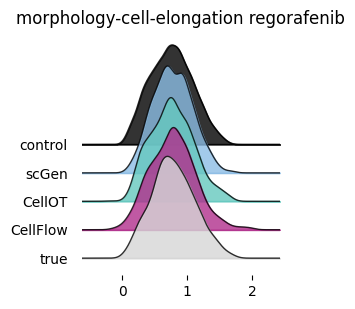

/home/icb/dominik.klein/mambaforge/envs/cellflow/lib/python3.12/site-packages/joypy/joyplot.py:176: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(by)


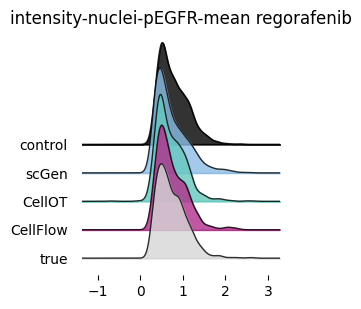

/home/icb/dominik.klein/mambaforge/envs/cellflow/lib/python3.12/site-packages/joypy/joyplot.py:176: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(by)


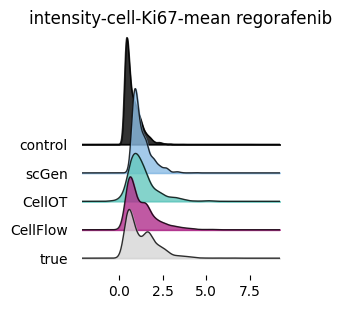

In [17]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import joypy


palette = ['#000000', "#8CBDE5", "#65C8BF", "#B12F8C", '#D6D6D6']
custom_cmap = ListedColormap(palette)

features = ["morphology-cell-elongation", "intensity-nuclei-pEGFR-mean", "intensity-cell-Ki67-mean"]

for i,feature in enumerate(features):
    fig, axes = joypy.joyplot(
        df[[feature, "method"]],
        by="method",
        colormap=custom_cmap,
        overlap=1.5,
        alpha=0.8,
        figsize=(3, 3),
        linewidth=1
    )
    plt.title(f"{feature} {drug}", fontsize=12)
    fig.savefig(f"/lustre/groups/ml01/workspace/ot_perturbation/figures/4i/joyplots/{drug}_{feature}.pdf")
    plt.show()
